In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q tensorflow_model_optimization

     |████████████████████████████████| 174kB 13.4MB/s 


In [3]:
import os
import requests
import tempfile
import zipfile
import shutil
import json
import time
import sys
import cv2
import numpy as np
import pandas as pd
from glob import glob
import subprocess
import matplotlib.pyplot as plt
import re
import string
%matplotlib inline


import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from keras.utils.layer_utils import count_params
import tensorflow_hub as hub
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity.keras import prune_low_magnitude
from sklearn.model_selection import train_test_split

In [4]:
data = pd.read_excel('/content/drive/MyDrive/AC295 Final Proj/data/training_set_rel3.xls')
data = data[~np.isnan(data['domain1_score'].values)]

In [5]:
data_dict = {}
data_x = {}
data_y = {}
num_classes = {}
for i in range(1,9):
  data_dict[i] = data[data.essay_set == i]
  data_x[i] = data_dict[i].essay.values
  data_y[i] = data_dict[i].domain1_score-min(data_dict[i].domain1_score)
  data_y[i] = to_categorical(data_y[i])
  num_classes[i] = data_y[i].shape[1]

In [6]:
train = {}
val = {}
for i in range(1,9):
  train_x, test_x, train_y, test_y = train_test_split(data_x[i], data_y[i], test_size = 0.2, random_state = 295)
  train[i] = (train_x, train_y)
  val[i] = (test_x, test_y)

#### Baseline Model:
Standard vectorization, followed by simple embedding and LSTM.

1. FFNN

In [7]:
def standardize_text(input_text):
  # Convert to lower case
  lowercase = tf.strings.lower(input_text)
  # Remove HTML tags
  stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
  return tf.strings.regex_replace(
      stripped_html, "[%s]" % re.escape(string.punctuation), ""
  )

def evaluate_model(model,test_data, training_results):
    
  # Get the model train history
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data)
  print("Evaluation Results:", evaluation_results)

In [8]:
max_features = 15000
sequence_length = 1000

text_vectorizer = TextVectorization(
    standardize=standardize_text,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

text_data = tf.data.Dataset.from_tensor_slices(data.essay.values)

text_vectorizer.adapt(text_data.batch(64))

def vectorize_text(text, label=None):
  text = tf.expand_dims(text, -1)
  text = text_vectorizer(text)
  if label is None:
    return text
  else:
    return text, label

In [9]:
batch_size = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data = {}
val_data = {}
for i in range(1,9):
  train_data[i] = tf.data.Dataset.from_tensor_slices(train[i])
  val_data[i] = tf.data.Dataset.from_tensor_slices(val[i])

  train_data[i] = train_data[i].batch(batch_size)
  train_data[i] = train_data[i].map(vectorize_text, num_parallel_calls=AUTOTUNE)
  train_data[i] = train_data[i].cache().prefetch(buffer_size=100)

  val_data[i] = val_data[i].batch(batch_size)
  val_data[i] = val_data[i].map(vectorize_text, num_parallel_calls=AUTOTUNE)
  val_data[i] = val_data[i].cache().prefetch(buffer_size=100)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               512512    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 6

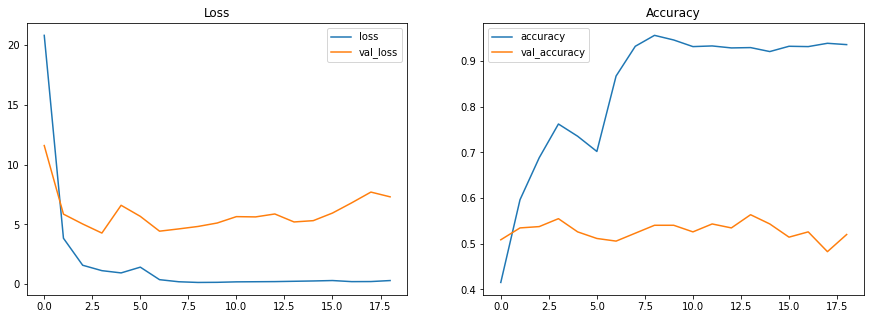

6/6 [==============================] - 0s 2ms/step - loss: 7.2999 - accuracy: 0.5202
Evaluation Results: [7.299911022186279, 0.5202311873435974]


In [10]:
# FFNN
i = 3
model = Sequential()
model.add(layers.Input(shape = (1000,)))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dense(num_classes[i], activation = 'softmax'))

model.summary()
loss = losses.categorical_crossentropy
model.compile(loss = loss, optimizer = 'Adam', metrics = 'accuracy')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='auto'
)

training_result=model.fit(train_data[i], validation_data = val_data[i], callbacks=early_stopping, epochs = 100, verbose = 1)
evaluate_model(model,val_data[i], training_result)

Performance in FFNN model is bad: almost no improvement in validation data.   
Potential reasons:  
1. These integer representation does not carry information of word meaning
2. The sample size is not large enough

2. Using Embedding + CNN

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 200)         3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 1000, 64)          38464     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 500, 64)           0         
_________________________________________________________________
flatten (Flatten)            (None, 32000)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8192256   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                

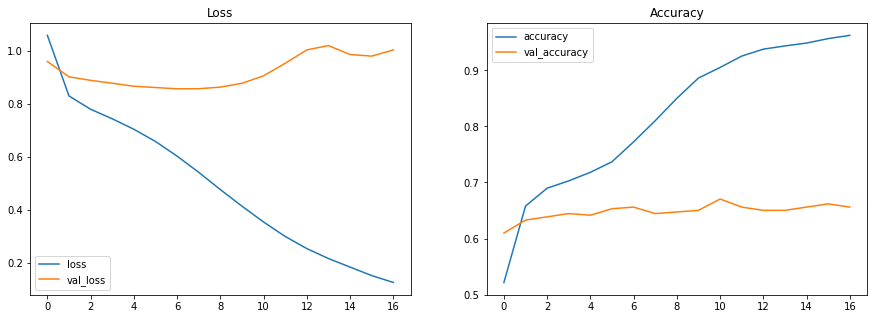

6/6 [==============================] - 0s 9ms/step - loss: 1.0034 - accuracy: 0.6561
Evaluation Results: [1.0034300088882446, 0.6560693383216858]


In [43]:
latent_dim=200 # latent space dimension of embedding
learning_rate = 0.0002
epochs = 100
loss = losses.categorical_crossentropy
optimizer = optimizers.Adam(learning_rate=learning_rate)
def embedding_cnn_model(i):
  K.clear_session()
  input=layers.Input(shape=(1000,))
  embedding=layers.Embedding(max_features,latent_dim)(input)
  conv1=layers.Conv1D(64,3,activation='relu',padding='same')(embedding)
  maxpool=layers.MaxPooling1D(pool_size=2)(conv1)
  flatten=layers.Flatten()(maxpool)
  dense=layers.Dense(256,activation='relu')(flatten)
  output=layers.Dense(num_classes[i],activation='softmax')(dense)
  model=Model(input,output)
  return model

i=3
model_em_cnn=embedding_cnn_model(i)
model_em_cnn.summary()

model_em_cnn.compile(loss = loss, optimizer = optimizer, metrics = 'accuracy')

training_result_em_cnn=model_em_cnn.fit(train_data[i], validation_data = val_data[i], callbacks=early_stopping, epochs = 100, verbose = 1)
evaluate_model(model_em_cnn,val_data[i], training_result_em_cnn)

3. Embedding + LSTM

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 16)          240000    
_________________________________________________________________
lstm (LSTM)                  (None, 10)                1080      
_________________________________________________________________
dense (Dense)                (None, 4)                 44        
Total params: 241,124
Trainable params: 241,124
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
23/23 [==============================] - 1s 58ms/step - loss: 1.3828 - accuracy: 0.3573 - val_loss: 1.3812 - val_accuracy: 0.3662
Epoch 2/100
23/23 [==============================] - 1s 40ms/step - loss: 1.3804 - accuracy: 0.3573 - va

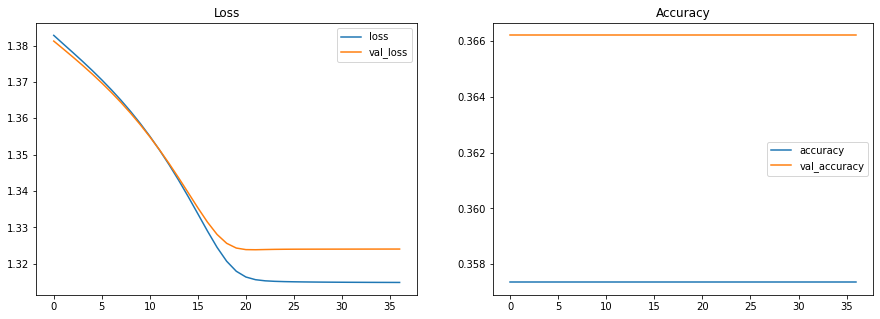

6/6 [==============================] - 0s 17ms/step - loss: 1.3240 - accuracy: 0.3662
Evaluation Results: [1.3240277767181396, 0.3661971688270569]


In [20]:
latent_dim=16 # latent space dimension of embedding
def embedding_lstm_model(i):
  K.clear_session()
  input=layers.Input(shape=(1000,))
  embedding=layers.Embedding(max_features,latent_dim)(input)
  lstm=layers.LSTM(10)(embedding)
  #dense=layers.Dense(16,activation='relu')(lstm)
  output=layers.Dense(num_classes[i],activation='softmax')(lstm)
  model=Model(input,output)
  return model

i=4
model_em_lstm=embedding_lstm_model(i)
model_em_lstm.summary()

learning_rate = 0.0001
epochs = 100
loss = losses.categorical_crossentropy
optimizer = optimizers.Adam(learning_rate=learning_rate)
#optimizer = optimizers.SGD(lr=0.1, decay=1e-2, momentum=0.9)
model_em_lstm.compile(loss = loss, optimizer = optimizer, metrics = 'accuracy')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='auto'
)
training_result_em_lstm=model_em_lstm.fit(train_data[i], validation_data = val_data[i], callbacks=early_stopping, epochs = 100, verbose = 1)
evaluate_model(model_em_lstm,val_data[i], training_result_em_lstm)

4. Embedding + RNN

In [21]:
latent_dim=64 # latent space dimension of embedding
def embedding_rnn_model(i):
  K.clear_session()
  input=layers.Input(shape=(1000,))
  embedding=layers.Embedding(max_features,latent_dim)(input)
  rnn=layers.SimpleRNN(100)(embedding)
  output=layers.Dense(num_classes[i],activation='softmax')(rnn)
  model=Model(input,output)
  return model

i=4
model_em_rnn=embedding_rnn_model(i)
model_em_rnn.summary()

learning_rate = 0.001
epochs = 100
loss = losses.categorical_crossentropy
optimizer = optimizers.Adam(learning_rate=learning_rate)
#optimizer = optimizers.SGD(lr=0.1, decay=1e-2, momentum=0.9)
model_em_rnn.compile(loss = loss, optimizer = optimizer, metrics = 'accuracy')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='auto'
)
training_result_em_rnn=model_em_rnn.fit(train_data[i], validation_data = val_data[i], callbacks=early_stopping, epochs = 100, verbose = 1)
evaluate_model(model_em_rnn,val_data[i], training_result_em_rnn)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 64)          960000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100)               16500     
_________________________________________________________________
dense (Dense)                (None, 4)                 404       
Total params: 976,904
Trainable params: 976,904
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
23/23 [==============================] - 17s 741ms/step - loss: 1.3332 - accuracy: 0.3665 - val_loss: 1.3316 - val_accuracy: 0.3662
Epoch 2/100
 3/23 [==>...........................] - ETA: 9s - loss: 1.3104 - accuracy: 0.3646

KeyboardInterrupt: ignored

5. Pre-trained embedding (glove) + LSTM (Transfer learning)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

Text vectorizer based on dataset

In [ ]:
vocabulary = text_vectorizer.get_vocabulary()
vocabulary_size = len(vocabulary)
print("Vocabulary Size:",vocabulary_size)
# Generate word index
word_index = dict(zip(vocabulary, range(vocabulary_size)))

Compared with glove

In [ ]:
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

In [ ]:
num_tokens = vocabulary_size 
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

In [ ]:
# glove embedding
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [24]:
def pre_embedding_cnn_model(i):
  K.clear_session()
  input=layers.Input(shape=(1000,))
  embedding=embedding_layer(input)
  conv1=layers.Conv1D(16,3,activation='relu')(embedding)
  flatten=layers.GlobalAveragePooling1D()(conv1)
  output=layers.Dense(num_classes[i],activation='softmax')(flatten)
  model=Model(input,output)
  return model

def pre_embedding_lstm_model(i):
  K.clear_session()
  input=layers.Input(shape=(1000,))
  embedding=embedding_layer(input)
  lstm=layers.LSTM(100)(embedding)
  flatten=layers.Dense(64,activation='relu')(lstm)
  output=layers.Dense(num_classes[i],activation='softmax')(flatten)
  model=Model(input,output)
  return model


In [ ]:
i=3

learning_rate = 0.001
epochs = 100

optimizer = optimizers.Adam(learning_rate=learning_rate)
loss=losses.categorical_crossentropy

model_glove_cnn=pre_embedding_cnn_model(i)
model_glove_cnn.compile(loss=loss,optimizer=optimizer, metrics=['accuracy'])
model_glove_cnn.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='auto'
)
training_result_glove_cnn=model_glove_cnn.fit(train_data[i], validation_data = val_data[i], callbacks=early_stopping, epochs = 100, verbose = 1)
evaluate_model(model_glove_cnn,val_data[i], training_result_glove_cnn)

In [ ]:
i=3

learning_rate = 0.001
epochs = 100

optimizer = optimizers.Adam(learning_rate=learning_rate)
loss=losses.categorical_crossentropy

model_glove_lstm=pre_embedding_lstm_model(i)
model_glove_lstm.compile(loss=loss,optimizer=optimizer, metrics=['accuracy'])
model_glove_lstm.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='auto'
)
training_result_glove_lstm=model_glove_lstm.fit(train_data[i], validation_data = val_data[i], callbacks=early_stopping, epochs = 100, verbose = 1)
evaluate_model(model_glove_lstm,val_data[i], training_result_glove_lstm)

In [25]:
def model_ffnn(i):
  K.clear_session()
  model = Sequential()
  model.add(layers.Input(shape = (1000,)))
  model.add(layers.Dense(512, activation = 'relu'))
  model.add(layers.Dense(256, activation = 'relu'))
  model.add(layers.Dense(128, activation = 'relu'))
  model.add(layers.Dense(64, activation = 'relu'))
  model.add(layers.Dense(32, activation = 'relu'))
  model.add(layers.Dense(16, activation = 'relu'))
  model.add(layers.Dense(num_classes[i], activation = 'softmax'))
  return model

# Summary for milestone 3

In [47]:
basemodel_result={}
for i in range(1,9):
  basemodel_result['essayset_'+str(i)]=[]

loss = losses.categorical_crossentropy
learning_rate = 0.0002
epochs = 100
optimizer = optimizers.Adam(learning_rate=learning_rate)
early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto'
  )

#FFNN
for i in range(1,9):
  model=model_ffnn(i)  
  model.compile(loss = loss, optimizer = optimizer, metrics = 'accuracy')
  training_result=model.fit(train_data[i], validation_data = val_data[i], callbacks=early_stopping, epochs = 100, verbose = 0)
  basemodel_result['essayset_'+str(i)].append(training_result.history['val_accuracy'][-1])
  print(f'FFNN for essay set {i} finished')
  

#embedding + CNN 1D
for i in range(1,9):
  model=embedding_cnn_model(i)
  model.compile(loss = loss, optimizer = optimizer, metrics = 'accuracy')
  training_result=model.fit(train_data[i], validation_data = val_data[i], callbacks=early_stopping, epochs = 100, verbose = 0)
  basemodel_result['essayset_'+str(i)].append(training_result.history['val_accuracy'][-1])
  print(f'embedding + CNN 1D for essay set {i} finished')
  

FFNN for essay set 1 finished
FFNN for essay set 2 finished
FFNN for essay set 3 finished
FFNN for essay set 4 finished
FFNN for essay set 5 finished
FFNN for essay set 6 finished
FFNN for essay set 7 finished
FFNN for essay set 8 finished
embedding + CNN 1D for essay set 1 finished
embedding + CNN 1D for essay set 2 finished
embedding + CNN 1D for essay set 3 finished
embedding + CNN 1D for essay set 4 finished
embedding + CNN 1D for essay set 5 finished
embedding + CNN 1D for essay set 6 finished
embedding + CNN 1D for essay set 7 finished
embedding + CNN 1D for essay set 8 finished


In [53]:
basemodel_summary=pd.DataFrame(basemodel_result).round(4)
basemodel_summary.index=['FFNN','Embedding + CNN 1D']
basemodel_summary

,essayset_1,essayset_2,essayset_3,essayset_4,essayset_5,essayset_6,essayset_7,essayset_8
FFNN,0.3081,0.4583,0.3497,0.4535,0.5069,0.4278,0.1401,0.1862
Embedding + CNN 1D,0.5602,0.6778,0.6474,0.6254,0.6565,0.5667,0.1656,0.2483
